In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics as m
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
# cross validation
from sklearn.model_selection import cross_val_score
# grid search
from sklearn.model_selection import GridSearchCV
# outlier
from sklearn.neighbors import LocalOutlierFactor
# imbalance handling
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [10]:
df = pd.read_pickle('dataset\cleaned_dementia_dataset.pkl')
df.head()

,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Group
0,0.0,0.0,1.0,0.0,27.0,5.0,1.0,14.0,0.0,284.0,35.0,1.0,Nondemented
1,1.0,15.0,1.0,0.0,28.0,5.0,1.0,17.0,0.0,285.0,20.0,0.0,Nondemented
2,0.0,0.0,1.0,0.0,15.0,3.0,1.0,10.0,1.0,231.0,73.0,52.0,Demented
3,1.0,32.0,1.0,0.0,16.0,3.0,1.0,15.0,1.0,254.0,51.0,32.0,Demented
4,2.0,185.0,1.0,0.0,20.0,3.0,1.0,9.0,1.0,238.0,40.0,46.0,Demented


# visualization

In [11]:
px.bar(df['SES'].value_counts(), x=df['SES'].value_counts().index, y='SES', title='SES')

In [12]:
px.bar(df['Group'].value_counts(), x=df['Group'].value_counts().index, y='Group', title='Group')

In [13]:
px.bar(df['M/F'].value_counts(), x=df['M/F'].value_counts().index, y='M/F', title='M/F')

In [14]:
px.bar(df, x='Group', y='MR Delay', color='M/F', title='MR Delay')

In [15]:
df['Group'].replace({'Converted': 0, 'Demented': 1, 'Nondemented': 2}, inplace=True)

<Axes: >

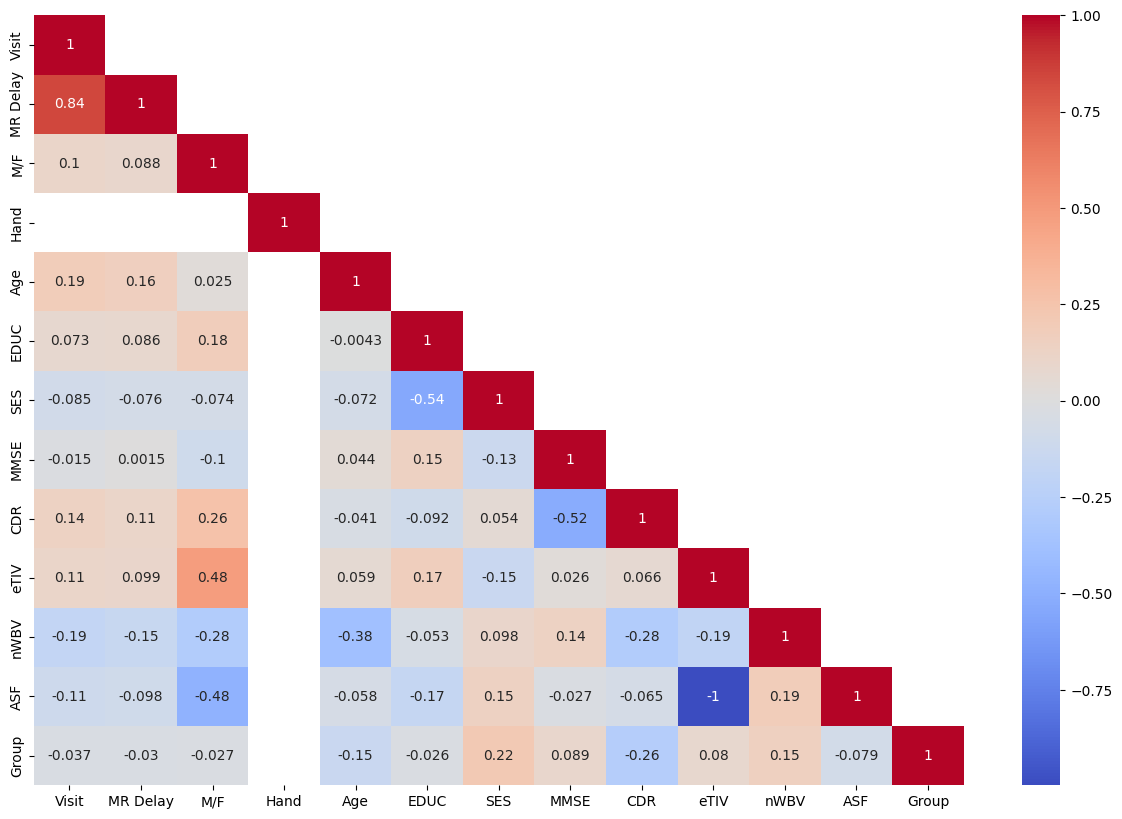

In [16]:
c = df.corr('kendall')
plt.figure(figsize=(15, 10))
# triangle correlation matrix
sns.heatmap(c, annot=True, cmap='coolwarm', mask=np.triu(c, k=1))

<Axes: title={'center': 'Correlation with Group'}>

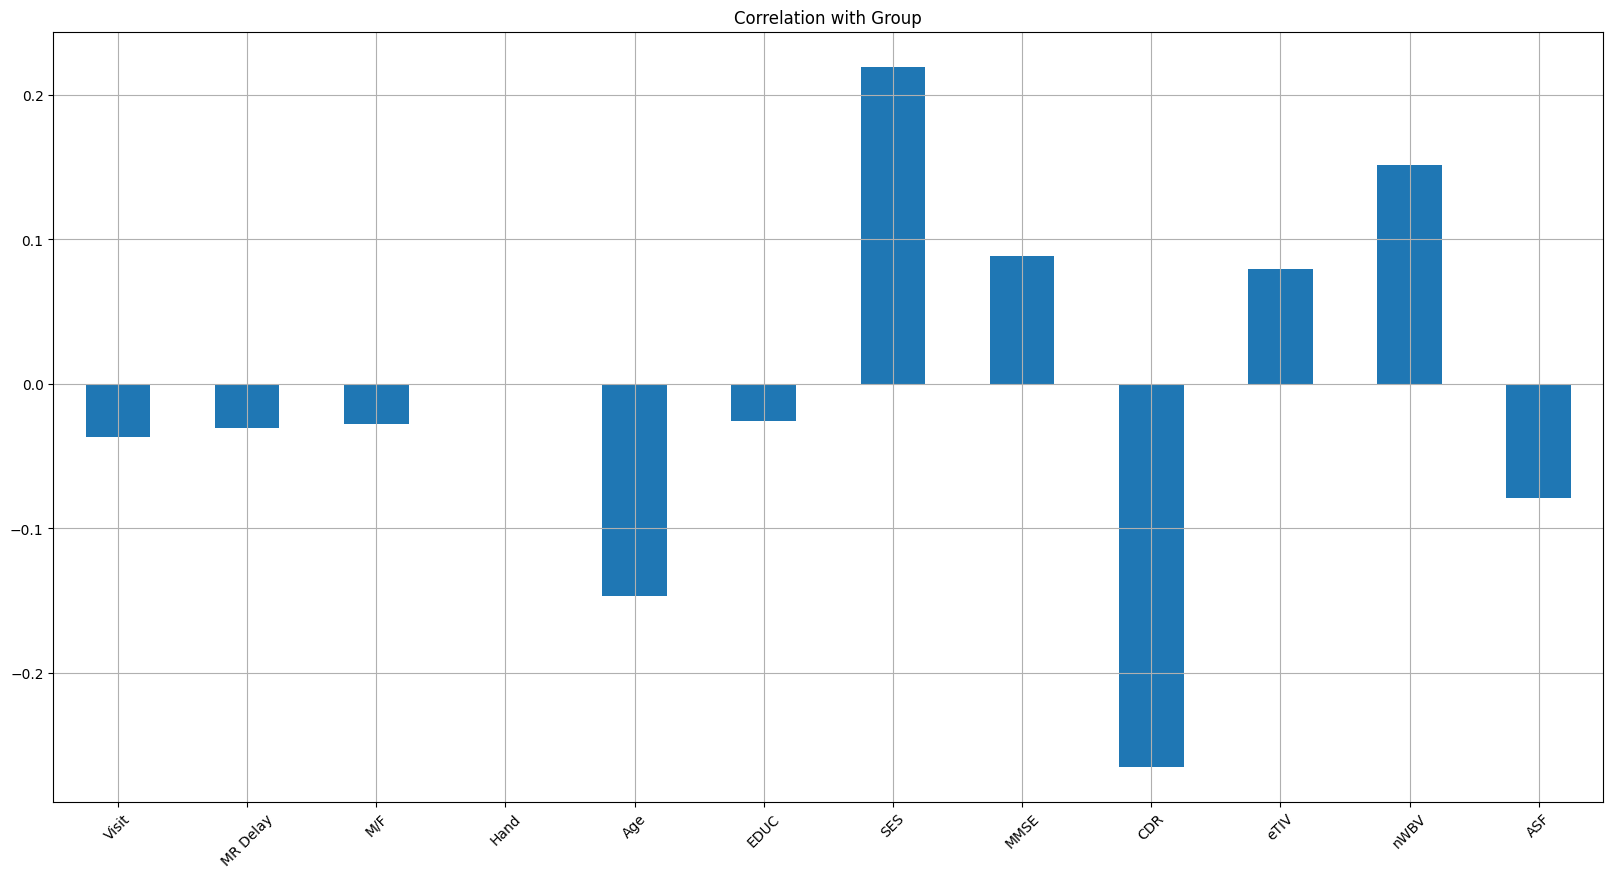

In [21]:
df.corrwith(df['Group'], method='kendall')[:-1].plot.bar(figsize=(20, 10), title='Correlation with Group', rot=45, grid=True)

feature selection

In [32]:
from sklearn.feature_selection import SelectKBest, chi2, RFECV, f_classif
from sklearn.ensemble import ExtraTreesClassifier

In [23]:
X = df.drop(['Group'], axis=1)
y = df['Group']

In [25]:
# list best features using CHI2
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Features', 'Score']
print(featureScores.nlargest(5, 'Score'))

    Features        Score
1   MR Delay  1488.546360
10      nWBV   750.779145
8        CDR   279.925479
9       eTIV   254.368794
11       ASF   194.133263


In [33]:
# list best features using RFECV
model = ExtraTreesClassifier()
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='accuracy', min_features_to_select=2)
rfecv.fit(X, y)
print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

Optimal number of features: 11
Selected features: ['Visit', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']


In [34]:
X.columns[rfecv.support_]

Index(['Visit', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF'],
      dtype='object')